In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(256, 256, count=2)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
#helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

(2, 256, 256, 3)
0 255
(2, 6, 256, 256)
0.0 1.0


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import cv2

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.numImageInput = 3
        self.count = count
        #self.input_images, self.target_masks = simulation.generate_random_data(256, 256, count=count)      
        #self.input_images, self.target_masks = self.get_images(3,3, count)
        self.get_images(3,3, count)
        
        #print(self.target_masks)
        #self.target_masks = np.reshape(self.target_masks, (count, 255, 255))
        print("Input: ", self.input_images.shape)
        print("Masks: ", self.target_masks.shape)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        #print("Image: "+str(image.shape))
        if self.transform:
            image = self.transform(image)

        return [image, mask]

    def get_images(self,X,Y, count):
        count+=self.numImageInput
        path = "/home/ubuntuos/WeatherTileExamples/scripts/output/cropped/" + "("+str(X)+", " + str(Y) +")/"
   
        files= os.listdir(path)
        images = []
        image_output = []
        #output = []
       
        
        for file in files:
            if file.endswith("("+str(X)+", "+str(Y)+").png"):
                images.append(file)
        #images = np.random.choice(np.array(images), count, replace=False)
        #print(np.random.choice(list(enumerate(np.array(images)[:count]))))
        
        images.sort()
        #rand_number = random.randint(0, len(images)-count)
        #images = images[rand_number:rand_number+count]
        
        rand_int = np.random.choice(len(images)-self.numImageInput, size=count, replace=False)
        
        print("Reading Images...")
        #for image_path in images:
        for i in range(len(images)):
            if (i in rand_int or i-1 in rand_int or i-2 in rand_int or i-self.numImageInput in rand_int):
                #input_path = os.path.join(path, image_path)
                input_path = os.path.join(path, images[i])
                an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                image_output.append(np.array(an_image))
            else:
                image_output.append(0)
        output_mask = []
        output = []
        
        
        #print(rand_int)
        print("Appending Images...")
        for i in range(count-self.numImageInput):
            #mask_temp = np.dstack((image_output[i+3]))
            mask_temp = [(np.round(image_output[rand_int[i]+self.numImageInput]/255*3)/3).astype("float16"),
                         (np.round(image_output[rand_int[i]+self.numImageInput]/255*3)/3).astype("float16"),
                         (np.round(image_output[rand_int[i]+self.numImageInput]/255*3)/3).astype("float16")]
    

            #print(rand_int[i])
            image_temp = np.dstack((image_output[rand_int[i]], image_output[rand_int[i]+1],image_output[rand_int[i]+2]))

            #image_temp = np.array([image_output[i], image_output[i+1],image_output[i+2]])
            output.append(image_temp)
            output_mask.append(mask_temp)
        self.input_images = np.array(output)
        #self.target_masks = np.divide(np.array(output_mask), 255)
        #self.target_masks = np.floor((np.array(output_mask)*4.0) / 255)/4
        #self.target_masks = np.rint(np.array(output_mask)*3.0 / 255) /3
        self.target_masks = np.array(output_mask)

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(100, transform=trans)
#train_set = SimDataset(1000, transform=trans)
val_set = SimDataset(10, transform=trans)
#val_set = SimDataset(100, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

#batch_size = 25
#batch_size = 20
batch_size = 3
#batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

Reading Images...
Appending Images...
Input:  (100, 256, 256, 3)
Masks:  (100, 3, 256, 256)
Reading Images...
Appending Images...
Input:  (10, 256, 256, 3)
Masks:  (10, 3, 256, 256)


{'train': 100, 'val': 10}

torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
-2.117904 0.68793046 -1.9328041 0.2722649
0.0 0.6665 0.01354 0.0663


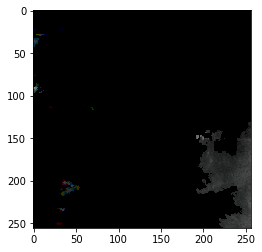

In [3]:
## import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))
#inputs = next(iter(dataloaders['train']))


print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[0]))

In [4]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [5]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

#summary(base_model, input_size=(3, 224, 224))
summary(base_model, input_size=(inputs[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [6]:
#### import torch
import torch.nn as nn

import resnet18 #added


def createUpLayer(in_channels, out_channels, kernel, padding):
    """return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)
    )"""
    """return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    )"""

    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel, padding=padding)
    )

def createDownLayer(size): #added
        return(nn.Sequential(
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.Conv2d(size, size*2, 3, stride = 2, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) #not in Google's model
        ))
        """return(nn.Sequential(
            resnet18.BasicBlock(size, size*2, stride = 2, downsample = nn.Sequential(
                    nn.Conv2d(size, size*2, 3, stride = 2, padding=1),
                    nn.BatchNorm2d(size*2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
                )),
            resnet18.BasicBlock(size*2, size*2, stride = 1)))"""
        
def createBasicLayer(size): #added
        return(nn.Sequential(
            nn.Conv2d(3, size, 3, stride = 2, padding=1),
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.Conv2d(size, size, 3, stride = 2, padding=1)
        ))


class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())       
   
        
        self.layer0 = createBasicLayer(64)
        self.layer1 = createDownLayer(64)  # size=(N, 128, x.H/8, x.W/8) # changed
        self.layer2 = createDownLayer(128)  # size=(N, 256, x.H/16, x.W/16)  # changed      
        self.layer3 = createDownLayer(256)  # size=(N, 512, x.H/32, x.W/32)  # changed
        
        self.layer4 = createDownLayer(512) # added
        self.layer5 = createDownLayer(1024) # added
        self.layer6 = createDownLayer(2048) # added
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        
        self.conv_up5 = createUpLayer(4096 + 2048, 2048, 3, 1) # added
        self.conv_up4 = createUpLayer(2048 + 1024, 1024, 3, 1) # added
        
        self.conv_up3 = createUpLayer(1024 + 512, 512, 3, 1)
        self.conv_up2 = createUpLayer(512 + 256, 256, 3, 1)
        self.conv_up1 = createUpLayer(256 + 128, 128, 3, 1)
        self.conv_up0 = createUpLayer(128, 64, 3, 1)
        
        """self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)"""

    def forward(self, input):
        """"x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)"""

        layer0 = self.layer0(input)    
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer5 = self.layer5(layer4) #added        
        
        layer6 = self.layer6(layer5) #added        
        #print(layer6.shape)
        x = layer6 # added
        #print(x.shape)

        x = torch.cat([x, layer5], dim=1)
        x = self.conv_up5(x) # added
        #print(x.shape)
        #print(layer4.shape)
        
        x = torch.cat([x, layer4], dim=1)
        x = self.conv_up4(x) # added

        #print(x.shape)
        #print(layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        #print(x.shape)
        #print(layer2.shape)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = torch.cat([x, layer0], dim=1)
        
        """x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)"""

        #return out
        return x

In [7]:
# check keras-like model summary using torchsummary

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = ResNetUNet(6)
model = ResNetUNet(3)

model = model.to(device)

#summary(model, input_size=(3, 224, 224))
#print(model)
summary(model, input_size=(inputs[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         LeakyReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
         Upsample-11          [-1, 128, 32, 32]               0
      BatchNorm2d-12          [-1, 128, 32, 32]             256
        LeakyReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [8]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):

 
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

#num_class = 6
num_class = 3

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in list(model.children()):
    for param in l.parameters():
        param.requires_grad = True

#optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
#optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
optimizer_ft = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=1)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=1/(10/len(str(batch_size))))
        
#model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)
#model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=int((2*train_set.count)**(1/3)))

cuda:1
Epoch 0/19
----------
LR 1


/home/ubuntuos/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


ValueError: Target size (torch.Size([3, 3, 256, 256])) must be the same as input size (torch.Size([3, 192, 64, 64]))

In [ ]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

print(pred.shape)
print(pred.max(), pred.min())
print(np.unique(pred))

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#print(np.unique(np.array(target_masks_rgb[0])))
#print(np.array((labels[0])))

#target_masks_rgb = [helper.masks_to_colorimg(x) for x in np.ceil(labels.cpu().numpy()*4.0)]
#pred_rgb = [helper.masks_to_colorimg(x) for x in np.floor(pred*4.0)]

target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()*3.0]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred*3.0]



print(labels.cpu().numpy()[0][0][0][0], pred[0][0][0][0])
print(target_masks_rgb[0][0][0], pred_rgb[0][0][0])

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
#torch.save(model, "/home/ubuntuos/pytorch-unet/pytorch_resnet18_unet_25000_trained")
#model = torch.load("/home/ubuntuos/pytorch-unet/pytorch_resnet18_unet_25000_trained")